# Extracting cards from a SET board

This notebook requires opencv for python (I used opencv-python) and matplotlib to be installed in your notebooks first.

In [364]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np

def show(img, title):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
    
def show_horizontal(images, titles, cols):
    fig = plt.figure(figsize=(18, 18))
    fig.tight_layout()
    number_of_files = len(images)
    for i, image in enumerate(images):
        a = fig.add_subplot(math.ceil(len(images) / cols), cols, i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def getSubImage(src, rect):
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D(center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, src.shape[:2])
    out = cv2.getRectSubPix(dst, size, center)

    if rect[1][1] > rect[1][0]:
        return rotate_bound(out, 90)

    return out

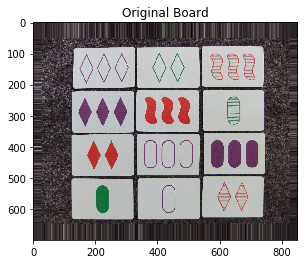

In [366]:
board = cv2.imread('JupyterSet/images/boards/board1.jpg', cv2.IMREAD_COLOR)
board = cv2.resize(board, (800, 600),interpolation = cv2.INTER_CUBIC)
board = cv2.copyMakeBorder(board, 50, 50, 25, 25, cv2.BORDER_REPLICATE)
show(board, 'Original Board')

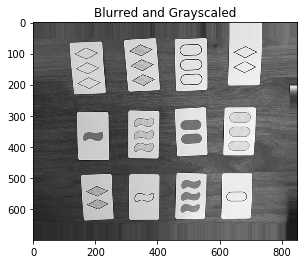

In [356]:
gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (1, 1), 0)
show(blurred, 'Blurred and Grayscaled')

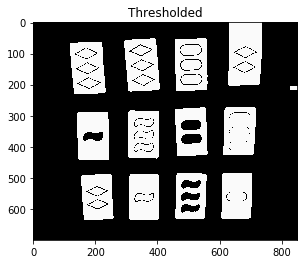

In [357]:
resultCode, thresh = cv2.threshold(blurred, 150, 250, cv2.THRESH_BINARY)
show(thresh, 'Thresholded')

Found 13 contours


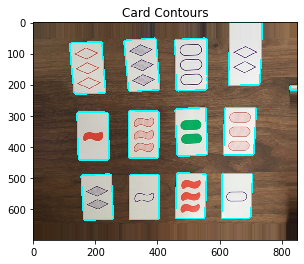

In [358]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = list(filter(lambda c: cv2.contourArea(c) > 200, contours))
print(f'Found {len(contours)} contours')
show(cv2.drawContours(board.copy(), contours, -1, (255,255,0), 3), 'Card Contours')

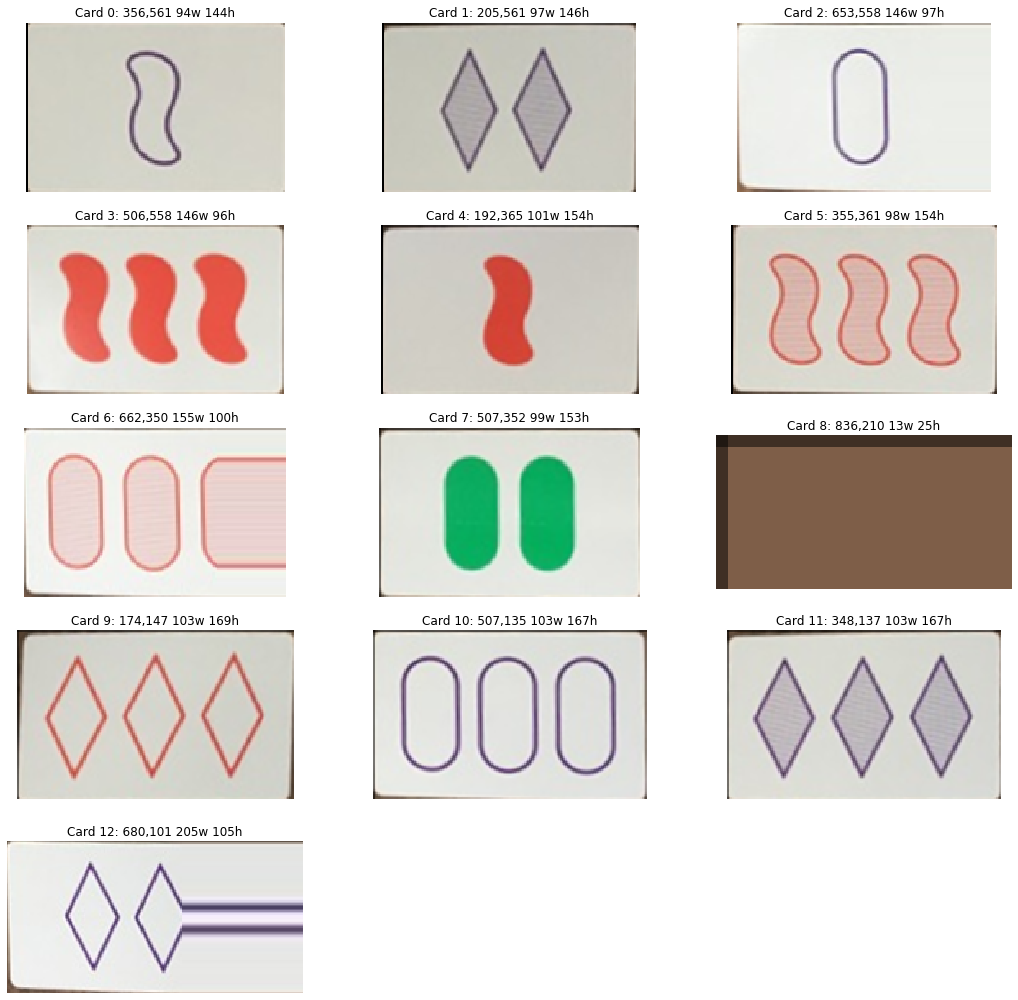

In [359]:
images = []
titles = []
for index, contour in enumerate(contours):
    rect = cv2.minAreaRect(contour)   
    cropped = getSubImage(board.copy(), rect)
    if len(cropped):
#        show(cropped, )
        cv2.imwrite(f'JupyterSet/images/unclassified/{index}.png', cropped)
        images.append(cropped)
        titles.append(f'Card {index}: {math.floor(rect[0][0])},{math.floor(rect[0][1])} {math.floor(rect[1][0])}w {math.floor(rect[1][1])}h')
    else:
        print(f'Could not extract card {index}')
show_horizontal(images, titles, 3)